In [1]:
## from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pandas as pd
import numpy as np
import scipy.optimize
import re
import os
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter



import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter

import xarray as xr

mpl.rcParams['figure.figsize'] = [8, 8]
mpl.rc('font',**{'size' : 18})

from IPython.display import clear_output

import itertools

In [2]:
# basedir = '/home/lee/OneDrive/Data/TRMC/Refined/freqdep/'
basedir = 'C:\\Users\\aspit\\OneDrive\\Data\\TRMC\\Refined\\Freqdep\\'
fps = {
#     'KCs' :  basedir + 'KCs/',
#     'PC' :  basedir + 'PC/',
#     'SP' :  basedir + 'SP/',

    'A' : basedir + 'Bi_A_2/',
    'D' : basedir + 'Bi_D_2/',
    'C' : basedir + 'Bi_C_2/'
    
}

# os.listdir(fps['SP'])

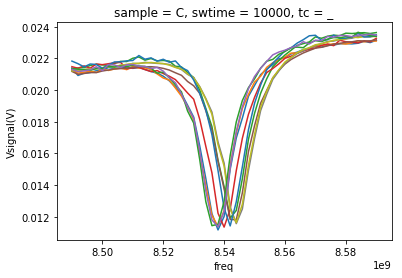

In [3]:
da_sw = load.sweeps2ds(fps)['Vsignal(V)']

for samp in fps:
    da1 = da_sw.sel(sample = samp).dropna(dim = 'tc', how = 'all').sel(tc = '_')
    for swtime in da1.indexes['swtime']:
        da1.sel(swtime = swtime).plot()

In [4]:
das = []
das_bv = []

for samp in fps:
    direc = os.path.join(fps[samp],'FreqFluence')
    print('Loading data for ' + samp)
    s_fps = load.freqfluence_flist(direc)
#     print(s_fps)
    s,backvs = load.freqfluence_load(s_fps)
    print('Converting to Dataset')
    da = xr.DataArray.from_series(s)
    da = da.expand_dims('sample')
    da['sample'] = [samp]
    das.append(da)
    
    da_bv = xr.DataArray.from_series(backvs)
    da_bv = da_bv.expand_dims('sample')
    da_bv['sample'] = [samp]
    das_bv.append(da_bv)
    
da_dv = xr.concat(das, dim = 'sample')
da_bv = xr.concat(das_bv,dim = 'sample')

Loading data for A
Converting to Dataset
Loading data for D
Converting to Dataset
Loading data for C
Converting to Dataset


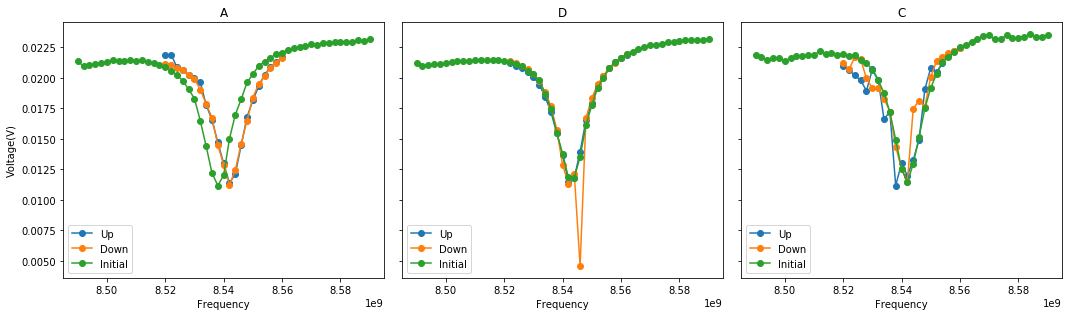

In [5]:
size = len(fps)
fig, axes = plt.subplots(1,size, figsize = (5*size,1.5*size) , sharey = True)

for i, samp in enumerate(fps):
    swp_bv_u = da_bv.sel(sample = samp, direction = 'U').dropna(dim = 'freq')
    axes[i].plot(swp_bv_u.indexes['freq'],swp_bv_u,marker = 'o', label = 'Up')
    swp_bv_d = da_bv.sel(sample = samp, direction = 'D').dropna(dim = 'freq')
    axes[i].plot(swp_bv_d.indexes['freq'],swp_bv_d,marker = 'o', label = 'Down')
    swp_init = da_sw.sel(sample = samp, tc = '_', swtime = 0)
    axes[i].plot(swp_init.indexes['freq'],swp_init,marker = 'o',label = 'Initial')
    axes[i].set_title(samp)
    axes[i].legend()
    axes[i].set_xlabel('Frequency')
    if i == 0: axes[i].set_ylabel('Voltage(V)') 
fig.tight_layout()

In [6]:
v0s_bv = da_bv.sel(direction = 'U')
v0s_sw = da_sw.sel(tc = '_',swtime = 0).dropna(dim = 'freq')

# v0_C = da_bv.sel(sample = 'C' , direction = 'D')
v0_C =  da_sw.sel(sample = 'C', tc = '_',swtime = 0).dropna(dim = 'freq')
v0_A = da_bv.sel(sample = 'A' , direction = 'D')
v0_A = v0_A.fillna(0.02164)
v0_D = da_bv.sel(sample = 'D' , direction = 'U')
v0_D = v0_D.fillna(0.02135)

v0_C_i = da_bv.sel(sample = 'C' , direction = 'D')
v0_C_i.loc[:] = np.interp(v0s_bv.indexes['freq'],v0_C.indexes['freq'],v0_C.values )
# v0_C_i.set_index({'sample': 'C'})

v0s = xr.concat([v0_C_i, v0_A, v0_D], dim = 'sample').drop('direction')

In [7]:
fittype = 'lor'
# fittype = 'poly'

if fittype == 'lor':
    Rinf = 0.02125
    f0 = 8.54e9
    p0 =[f0,1e7,0.01, Rinf]
    p_labels = ['f0','w','R','Rinf'] 
    epsilon = 0.00001
#     bounds = ([0,0,0, Rinf - epsilon],[np.inf,np.inf,np.inf, Rinf + epsilon])
    bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
    window = 100

elif fittype == 'poly':
    window = 2
    p_labels = ['R', 'f0', 'p0','p1','p2']
    bounds = ([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
    p0 = [.01,1e-9,1e-18]


In [8]:
da_p = da_dv.isel(freq = 0).drop('freq').where(False).copy()
da_p0 = da_sw.sel(tc = '_',swtime = 0).isel(freq = 0).drop('tc').drop('swtime').drop('freq').where(False).copy()

da_p_dict = {}
da_p0_dict = {}
for p in p_labels:
    da_p_dict[p] = da_p
    da_p0_dict[p] = da_p0
    
#Not exactly sure why I have to do this copying. Otherwise I think the reference to the original numpy array is kept and assignments get all weird
ds_p = xr.Dataset(da_p_dict).copy(deep=True)
ds_p0 = xr.Dataset(da_p0_dict).copy(deep=True)


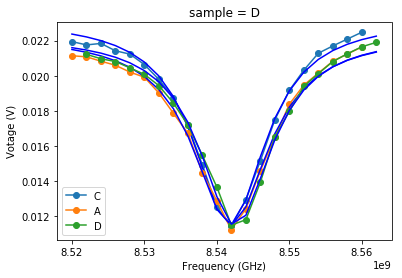

In [9]:
v0_fits = v0s.copy()

samples = v0s.indexes['sample']
freqs_i = da_dv.indexes['freq']
mi = pd.MultiIndex.from_product([samples,freqs_i], names = ['sample', 'freq'])
s = pd.Series(index = mi)
v0s_i = xr.DataArray.from_series(s)


for samp in v0s.indexes['sample']:
    v0 = v0s.loc[samp]
    dv = da_dv.sel(sample = samp, direction = 'U', time = 0).dropna(dim = 'fluence', how = 'all').isel(fluence = -1).dropna(dim = 'freq')
    freqs = dv.indexes['freq']
    
    v0s_i.loc[samp] = v0.interp(freq = freqs).reindex(freq = freqs_i)
    
    v0_fit, v0_p,v0_sl = analysis.fitsweep(v0, p0, bounds, window , fittype,p_labels)
    freqs = v0s.indexes['freq'][v0_sl]
    v0_fits.loc[samp] = v0_fit(freqs)
    
    v0s_i.loc[samp].plot(marker = 'o', label = samp)
    v0_fits.loc[samp].plot(color = 'b')
    
    for i, p in enumerate(ds_p0.data_vars):
        ds_p0[p].loc[samp] = v0_p[i]
    
#     K[sample] = analysis.calc_K(f0 = popt[0], w = popt[1], R0 = popt[2], printparams = False)

plt.xlabel('Frequency (GHz)')
plt.ylabel('Votage (V)')
plt.legend()

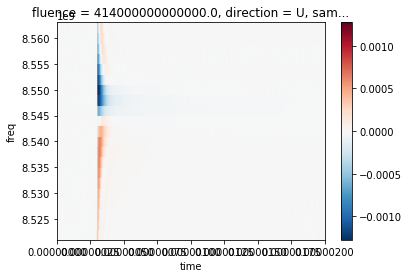

In [10]:
data = da_dv.sel(sample = 'D', direction = 'U').dropna(dim = 'fluence', how = 'all').isel(fluence = -1).dropna(dim = 'freq', how = 'all')
data.plot()

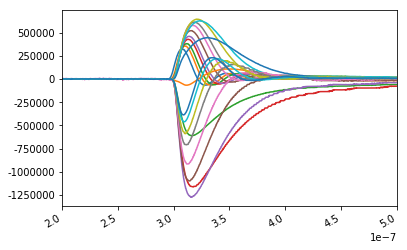

In [11]:
fig, ax = plt.subplots()

freqs = data.indexes['freq']
for freq in freqs:
    trace = data.sel(freq = freq)
    ax.plot(trace.to_series())

expf = exp_formatter(-9)
ax.yaxis.set_major_formatter(FuncFormatter(expf.format_func))

ax.set_xlim(200e-9,500e-9)
fig.autofmt_xdate()

In [12]:
time1 = 250e-9
time2 = 1000e-9
step = 200

times = da_dv.indexes['time']
timesel1 = pd.Series(abs(times-time1)).idxmin()
timesel2 = pd.Series(abs(times-time2)).idxmin()

times = times[slice(timesel1,timesel2,step)]

In [13]:
ds_p_r  =  ds_p.sel(direction = 'U').drop(['direction']).sel(time = times).copy(deep = True)
dvs = da_dv.sel( direction = 'U').dropna(dim = 'freq', how = 'all').sel(time = times)

# dvs
vss = v0s - dvs
fits = vss.copy(deep = True)

cds = ds_p_r.coords

num = len(cds['fluence'])*len(cds['sample'])*len(cds['time'])
i=0

for samp in vss.indexes['sample']:
    vs1 = vss.sel(sample = samp).dropna('fluence','all')   
    for flu in vs1.indexes['fluence']:
        vs2 = vs1.sel(fluence = flu).dropna('time','all')
        for time in vs2.indexes['time']:
            i=i+1
            clear_output(wait = True)
            print(str((i/num)*300) + ' %') #Not sure where this factor of 3 is coming from, see num above. 
            
            vs3 = vs2.sel(time = time).dropna('freq')
            vs_fit, vs_p,vs_sl = analysis.fitsweep(vs3, p0, bounds, window , fittype,p_labels)

            freqs = vs2.indexes['freq'][vs_sl]
            fits.loc[samp,:,flu,time] = vs_fit(freqs).values
            ds_p_r['f0'].loc[samp,flu,time] = vs_p[0]
            ds_p_r['w'].loc[samp,flu,time] = vs_p[1]
            ds_p_r['R'].loc[samp,flu,time] = vs_p[2]
            ds_p_r['Rinf'].loc[samp,flu,time] = vs_p[3]
                    
fits.name = 'fits'
dvs.name = 'dvs'
vss.name = 'vss'
            
das = [dvs,fits,vss]
ds = xr.merge(das)

100.0 %


(<Figure size 504x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000197CD926978>,
       dtype=object))

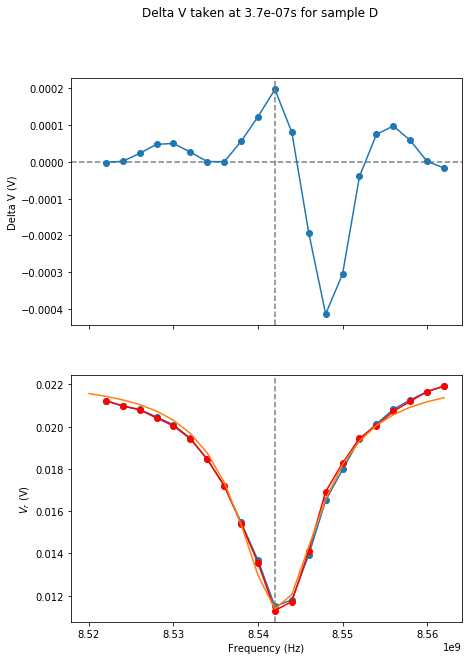

In [14]:
samp = 'D'

dst = ds.sel(sample = samp).dropna('fluence','all').isel(fluence = -1)
v0 = v0s_i.sel(sample = samp)

plot.vsplotxr(350, dst['dvs'], vss= dst['vss'], fits = dst['fits'], v0 = v0, v0_fit = None)

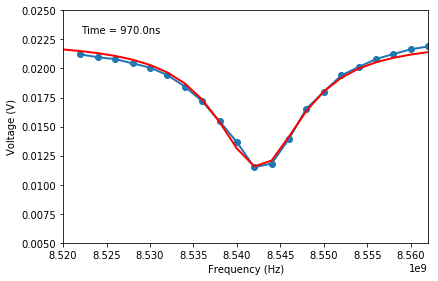

In [15]:
plot.sweepfitanim(dst)

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\matplotlib\ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\matplotlib\ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\matplotlib\ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


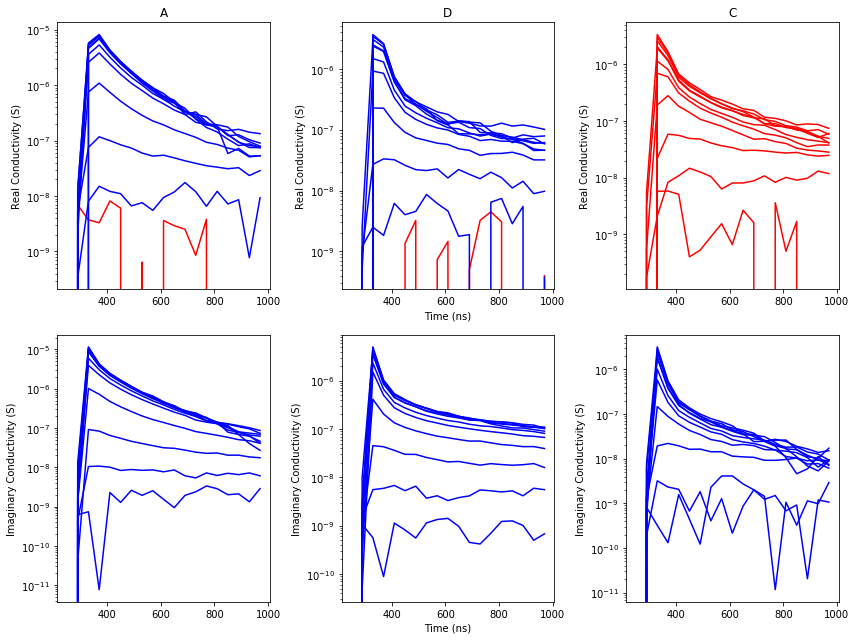

In [16]:
fig, axes = plt.subplots(2,3, figsize = (12,9))

e0 = 8.854e-12
F=1

for i , samp in enumerate(ds_p_r.indexes['sample']):
    ft = ds_p_r['f0'].sel(sample = samp).dropna('fluence')
    f0 = ft.isel(time = 0)
    deltaf = abs(ft-f0)
    sig_I_a = -1*deltaf*e0/F

    wt = ds_p_r['w'].sel(sample = samp).dropna('fluence')
    w0 = wt.isel(time = 0)
    deltaFWHM = wt - w0
    sig_R_a = deltaFWHM*e0/(2*F)

    # sig_R = (1/K['KCs'])*(deltaR/v0_p['R'])
    for fluence in sig_R_a.indexes['fluence']:
        sig_R = sig_R_a.sel(fluence = fluence)
        sig_I = sig_I_a.sel(fluence = fluence)

        label = '$\sigma^{\'}(\Delta FWHM)$'

        ax = axes[0][i]
        sig_R = sig_R.to_series()
        if np.trapz(sig_R) < 0:
            color = 'b'
            sig_R = sig_R*-1
        else:
            color = 'r'
        ax.plot(sig_R, label = label, color = color)
        ax.set_yscale('log')
        ax.set_ylabel('Real Conductivity (S)')

        ax = axes[1][i]
        sig_I = sig_I.to_series()
        if np.trapz(sig_I) < 0:
            color = 'b'
            sig_I = sig_I*-1
        else:
            color = 'r'
        ax.plot(sig_I, label = '$\sigma^{\'\'}(\Delta\omega)$', color = color)
        ax.set_yscale('log')
        ax.set_ylabel('Imaginary Conductivity (S)')

    axes[0][i].set_title(samp)
for axs in axes:
    for ax in axs:
        ax.xaxis.set_major_formatter(FuncFormatter(exp_formatter(-9).format_func))
#         axes.set_xlim(250e-9,1200e-9)
    axs[1].set_xlabel('Time (ns)')

        # axes.set_ylim([1e-8,1e-4])

fig.tight_layout()